In [0]:
#@title `StyleGAN-Encoder`
!git clone https://github.com/pbaylies/stylegan-encoder
%cd stylegan-encoder
!ls
!rm -rf aligned_images raw_images
!mkdir aligned_images raw_images

Cloning into 'stylegan-encoder'...
remote: Enumerating objects: 483, done.
remote: Total 483 (delta 0), reused 0 (delta 0), pack-reused 483
Receiving objects: 100% (483/483), 12.75 MiB | 24.31 MiB/s, done.
Resolving deltas: 100% (264/264), done.
/content/stylegan-encoder
adaptive.py			       Play_with_latent_directions.ipynb
align_images.py			       pretrained_example.py
config.py			       README.md
dataset_tool.py			       requirements.txt
dnnlib				       robust_loss
encode_images.py		       run_metrics.py
encoder				       StyleGAN_Encoder_Tutorial.ipynb
ffhq_dataset			       swa.py
generate_figures.py		       teaser.png
Learn_direction_in_latent_space.ipynb  train_effnet.py
LICENSE.txt			       training
metrics				       train.py
mona_example.jpg		       train_resnet.py


In [0]:
#@title `Images through Webcam`
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import io
from PIL import Image
from datetime import datetime

VIDEO_HTML = """
<video autoplay
 width=%d height=%d style='cursor: pointer;'></video>
<script>

var video = document.querySelector('video')

navigator.mediaDevices.getUserMedia({ video: true })
  .then(stream=> video.srcObject = stream)
  
var data = new Promise(resolve=>{
  video.onclick = ()=>{
    var canvas = document.createElement('canvas')
    var [w,h] = [video.offsetWidth, video.offsetHeight]
    canvas.width = w
    canvas.height = h
    canvas.getContext('2d')
          .drawImage(video, 0, 0, w, h)
    video.srcObject.getVideoTracks()[0].stop()
    video.replaceWith(canvas)
    resolve(canvas.toDataURL('image/jpeg', %f))
  }
})
</script>
"""

def take_photo(quality=1.0, size=(800,600)):
  display(HTML(VIDEO_HTML % (size[0],size[1],quality)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  f = io.BytesIO(binary)
  img = np.asarray(Image.open(f))
  
  timestampStr = datetime.now().strftime("%d-%b-%Y (%H:%M:%S.%f)")
  filename = 'raw_images/photo_%s.jpeg' %timestampStr
  Image.fromarray(img).save(filename)
  print('Image captured and saved to %s' %filename)

img = take_photo() # click the image to capture a frame!

Image captured and saved to raw_images/photo_10-Jun-2020 (01:53:01.884820).jpeg


Found 2 images in raw_images
['Amr3.jpg', 'photo_10-Jun-2020 (01:53:01.884820).jpeg']


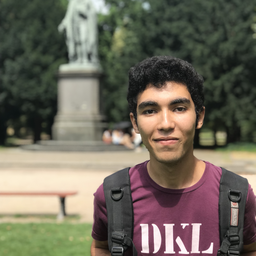

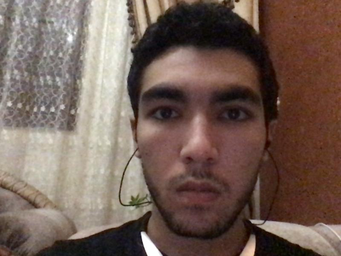

In [0]:
#@title `Get all raw images`
from PIL import Image
import os
imgs = sorted(os.listdir('raw_images'))

print("Found %d images in %s" %(len(imgs), 'raw_images'))
if len(imgs) == 0:
  print("Upload images to the \"raw_images\" folder!")
else:
  print(imgs)

for img_path in imgs:
  img = Image.open('raw_images/' + img_path)
  
  w,h = img.size
  rescale_ratio = 256 / min(w,h)
  img = img.resize((int(rescale_ratio*w),int(rescale_ratio*h)), Image.LANCZOS)
  display(img)

In [0]:
#@title `Selecting Tensorflow 1.x`
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


In [0]:
#@title `Auto-Aligning Faces`
# Look for faces in the images
# Crop out the faces from the images
# Align the faces (center the nose and make the eyes horizontal)
# Rescale the resulting images and save them in "aligned_images" folder

!python align_images.py raw_images/ aligned_images/ --output_size=1024

Using TensorFlow backend.
64045056/64040097 [==============================] - 2s 0us/step
Aligning photo_10-Jun-2020 (01:53:01.884820).jpeg ...
Getting landmarks...
Starting face alignment...
Wrote result aligned_images/photo_10-Jun-2020 (01:53:01.884820)_01.png
Aligning Amr3.jpg ...
Getting landmarks...
Starting face alignment...
Wrote result aligned_images/Amr3_01.png


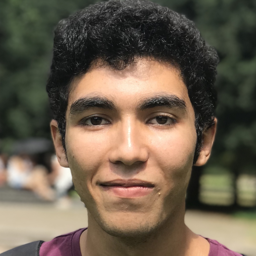

'img 0: Amr3_01.png'

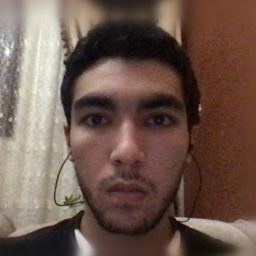

'img 1: photo_10-Jun-2020 (01:53:01.884820)_01.png'

In [0]:
#@title `Checking Newly Aligned Photos`

def display_folder_content(folder, res = 256):
  if folder[-1] != '/': folder += '/'
  for i, img_path in enumerate(sorted(os.listdir(folder))):
    if '.png' in img_path:
      display(Image.open(folder+img_path).resize((res,res)), 'img %d: %s' %(i, img_path))
      print('\n')
      
display_folder_content('aligned_images')

In [0]:
#@title `Encoding faces into StyleGAN Latent Space`
print('Download a pretrained resnet encoder...')
# model takes an image as input and estimates the corresponding latent code
!gdown https://drive.google.com/uc?id=1aT59NFy9-bNyXjDuZOTMl0qX0jmZc6Zb
!mkdir data
!mv finetuned_resnet.h5 data
!rm -rf generated_images latent_representations

Download a pretrained resnet encoder...
Downloading...
From: https://drive.google.com/uc?id=1aT59NFy9-bNyXjDuZOTMl0qX0jmZc6Zb
To: /content/stylegan-encoder/finetuned_resnet.h5
330MB [00:06, 52.9MB/s]


In [0]:
print("aligned_images contains %d images ready for encoding!" %len(os.listdir('aligned_images/')))
print("Recommended batch_size for the encode_images process: %d" %min(len(os.listdir('aligned_images/')), 8))

aligned_images contains 2 images ready for encoding!
Recommended batch_size for the encode_images process: 2


In [0]:
FAST=True

if FAST:
  print("\n************ Start FAST Latent code optimization process ***************")
  !python encode_images.py --optimizer=lbfgs --face_mask=True --iterations=6 --use_lpips_loss=0 --use_discriminator_loss=0 --output_video=True aligned_images/ generated_images/ latent_representations/
else:
  print("\n************ Start SLOW Latent code optimization process ***************")
  !python encode_images.py --optimizer=adam --lr=0.02 --decay_rate=0.95 --decay_steps=6 --use_l1_penalty=0.3 --face_mask=True --iterations=400 --early_stopping=True --early_stopping_threshold=0.05 --average_best_loss=0.5 --use_lpips_loss=0 --use_discriminator_loss=0 --output_video=True aligned_images/ generated_images/ latent_representations/

print("\n************ Latent code optimization finished! ***************")


************ Start FAST Latent code optimization process ***************



Using TensorFlow backend.










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




Instructions for updating:
If using Keras pass *_constraint arguments to layers.

58892288/58889256 [==============================] - 1s 0us/step
  0% 0/2 [00:00<?, ?it/s]WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:431: The name tf.is_variable_initialized is deprecated. Please use tf.compat.v1.is_variable_initialized instead.


Saving mask masks/Amr3_01.png
Loading ResNet Model:

  0% 0/6 [00:00<?, ?it/s]WARNING:tensorflow:
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend

In [0]:
#@title `loading StyleGAN network into memory`

import dnnlib, pickle
import dnnlib.tflib as tflib
tflib.init_tf()
synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True), minibatch_size=1)

model_dir = 'cache/'
model_path = [model_dir+f for f in os.listdir(model_dir) if 'stylegan-ffhq' in f][0]
print("Loading StyleGAN model from %s..." %model_path)

with dnnlib.util.open_url(model_path) as f:
  generator_network, discriminator_network, averaged_generator_network = pickle.load(f)
  
print("StyleGAN loaded & ready for sampling!")







Loading StyleGAN model from cache/263e666dc20e26dcbfa514733c1d1f81_karras2019stylegan-ffhq-1024x1024.pkl...







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
StyleGAN loaded & ready for sampling!


In [0]:
#@title `images viz utils`

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


def generate_images(generator, latent_vector, z = True):
    batch_size = latent_vector.shape[0]
    
    if z: #Start from z: run the full generator network
        return generator.run(latent_vector.reshape((batch_size, 512)), None, randomize_noise=False, **synthesis_kwargs)
    else: #Start from w: skip the mapping network
        return generator.components.synthesis.run(latent_vector.reshape((batch_size, 18, 512)), randomize_noise=False, **synthesis_kwargs)

def plot_imgs(model, rows, columns):
  for i in range(rows):
    f, axarr = plt.subplots(1,columns, figsize = (20,8))
    for j in range(columns):
      img = generate_images(model, np.random.randn(1,512), z = True)[0]
      axarr[j].imshow(img)
      axarr[j].axis('off')
      axarr[j].set_title('Resolution: %s' %str(img.shape))
    plt.show()

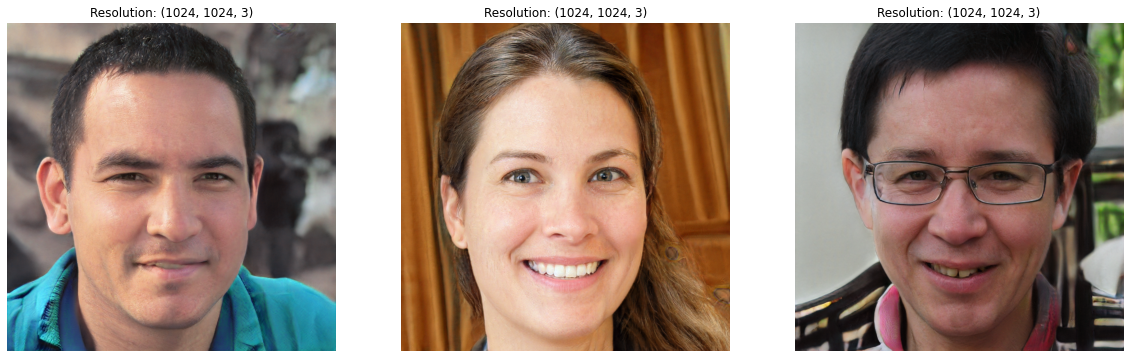

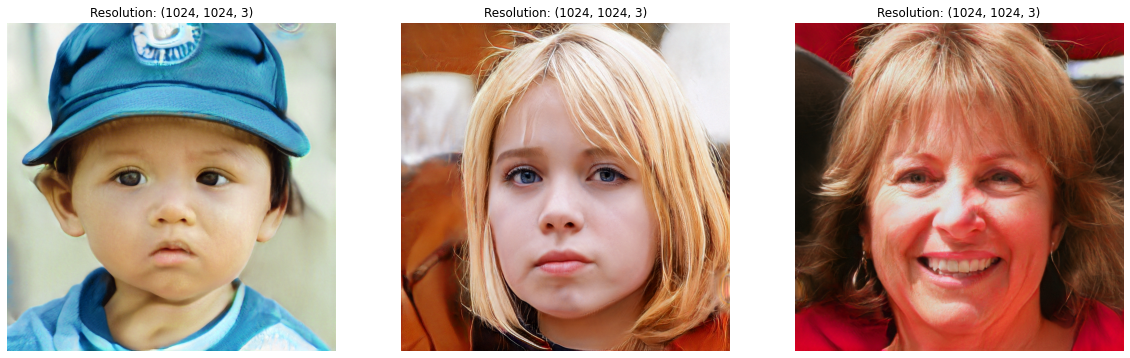

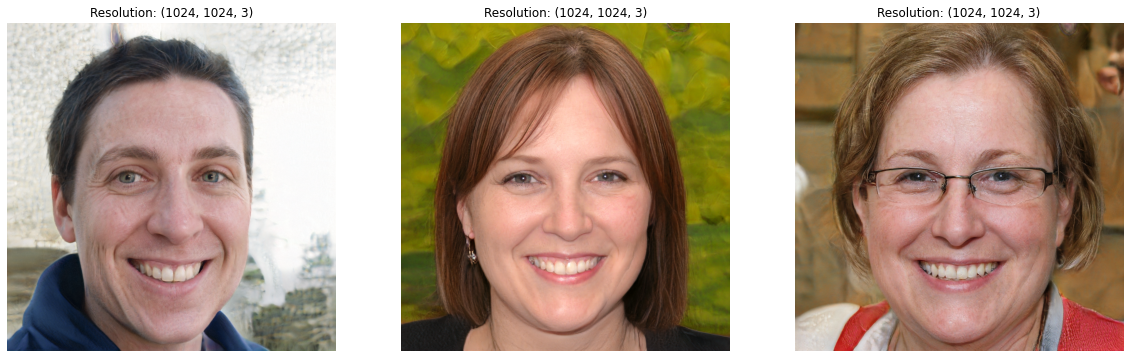

In [0]:
#@title `Plotting random StyleGAN Samples`
plot_imgs(averaged_generator_network, 3, 3)

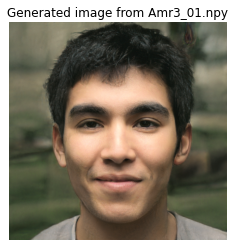

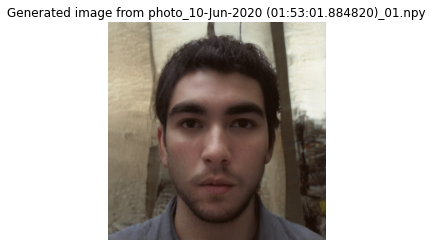

In [0]:
#@title `Results of Encoding`

for f in sorted(os.listdir('latent_representations')):
  w = np.load('latent_representations/' + f).reshape((1,18,-1))
  img = generate_images(averaged_generator_network, w, z = False)[0]
  plt.imshow(img)
  plt.axis('off')
  plt.title("Generated image from %s" %f)
  plt.show()

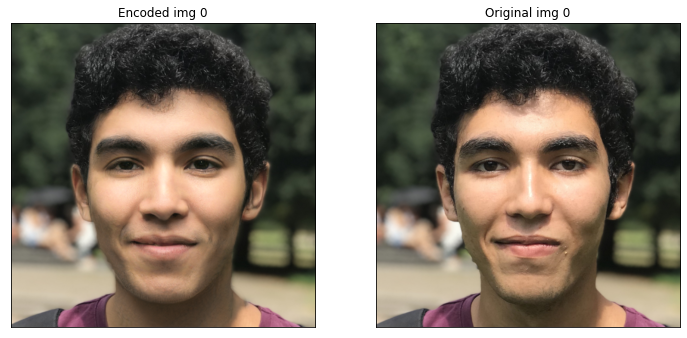

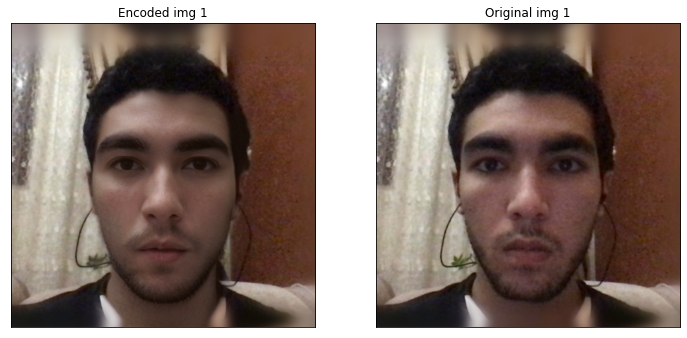

In [0]:
#@title `Compare encoded samples with the original ones`

def plot_two_images(img1,img2, img_id, fs = 12):
  f, axarr = plt.subplots(1,2, figsize=(fs,fs))
  axarr[0].imshow(img1)
  axarr[0].title.set_text('Encoded img %d' %img_id)
  axarr[1].imshow(img2)
  axarr[1].title.set_text('Original img %d' %img_id)
  plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
  plt.show()

def display_sbs(folder1, folder2, res = 256):
  if folder1[-1] != '/': folder1 += '/'
  if folder2[-1] != '/': folder2 += '/'
    
  imgs1 = sorted([f for f in os.listdir(folder1) if '.png' in f])
  imgs2 = sorted([f for f in os.listdir(folder2) if '.png' in f])
  if len(imgs1)!=len(imgs2):
    print("Found different amount of images in aligned vs raw image directories. That's not supposed to happen...")
  
  for i in range(len(imgs1)):
    img1 = Image.open(folder1+imgs1[i]).resize((res,res))
    img2 = Image.open(folder2+imgs2[i]).resize((res,res))
    plot_two_images(img1,img2, i)
    print("")
     
display_sbs('generated_images/', 'aligned_images/', res = 512)

In [0]:
#@title `Cherry pick images & dump latent vectors to disk`

good_images = [i for i in range(2)] # encoded images numbers

latents = sorted(os.listdir('latent_representations'))

out_file = '/content/output_vectors.npy'

final_w_vectors = []
for img_id in good_images:
  w = np.load('latent_representations/' + latents[img_id])
  final_w_vectors.append(w)

final_w_vectors = np.array(final_w_vectors)
np.save(out_file, final_w_vectors)
print("%d latent vectors of shape %s saved to %s!" %(len(good_images), str(w.shape), out_file))

2 latent vectors of shape (18, 512) saved to /content/output_vectors.npy!


# Manipulating the faces

In [0]:
#@title `Cloning InterFaceGAN`
%cd /content/
!git clone https://github.com/ShenYujun/InterFaceGAN
%cd InterFaceGAN

/content
Cloning into 'InterFaceGAN'...
remote: Enumerating objects: 223, done.
remote: Total 223 (delta 0), reused 0 (delta 0), pack-reused 223
Receiving objects: 100% (223/223), 11.38 MiB | 24.96 MiB/s, done.
Resolving deltas: 100% (70/70), done.
/content/InterFaceGAN


In [0]:
#@title `Download the pretrained StyleGAN FFHQ network from NVIDIA`
!gdown https://drive.google.com/uc?id=1MEGjdvVpUsu1jB4zrXZN7Y4kBBOzizDQ
!mv karras2019stylegan-ffhq-1024x1024.pkl /content/InterFaceGAN/models/pretrain/karras2019stylegan-ffhq-1024x1024.pkl

Downloading...
From: https://drive.google.com/uc?id=1MEGjdvVpUsu1jB4zrXZN7Y4kBBOzizDQ
To: /content/InterFaceGAN/karras2019stylegan-ffhq-1024x1024.pkl
325MB [00:02, 151MB/s]


In [0]:
#@title `Load Our custom latent space vectors`

final_w_vectors = np.load('/content/output_vectors.npy')

print("%d latent vectors of shape %s loaded from %s!" %(final_w_vectors.shape[0], str(final_w_vectors.shape[1:]), 'output_vectors.npy'))

2 latent vectors of shape (18, 512) loaded from output_vectors.npy!


In [0]:
#@title `Boundaries`

# Some Attr Boundaries (-b argument)
# Boundaries: https://github.com/ShenYujun/InterFaceGAN/tree/master/boundaries

# stylegan_ffhq_age_w_boundary.npy
# stylegan_ffhq_eyeglasses_w_boundary.npy
# stylegan_ffhq_gender_w_boundary.npy
# stylegan_ffhq_pose_w_boundary.npy
# stylegan_ffhq_smile_w_boundary.npy

In [0]:
#@title `Latent Space Configs`

latent_direction = 'age'      #@param ['age', 'eyeglasses', 'gender', 'pose', 'smile'] {allow-input: true}

# Controls how strongly we push the face into a certain latent direction (try 1-5)
morph_strength = 3           #@param {type:"slider", min:0, max:5, step:1} 

# The amount of intermediate steps/frames to render along the interpolation path
nr_interpolation_steps = 48  #@param {type:"slider", min:0, max:100, step:1} 

In [0]:
boundary_file = 'stylegan_ffhq_%s_w_boundary.npy' %latent_direction

print("Ready to start manipulating faces in the ** %s ** direction!" %latent_direction)
print("Interpolation from %d to %d with %d intermediate frames." %(-morph_strength, morph_strength, nr_interpolation_steps))
print("\nLoading latent directions from %s" %boundary_file)

Ready to start manipulating faces in the ** age ** direction!
Interpolation from -3 to 3 with 48 intermediate frames.

Loading latent directions from stylegan_ffhq_age_w_boundary.npy


In [0]:
#@title `Running latent interpolations`
import subprocess
return_code = subprocess.call("rm -r results/%s" %latent_direction, shell=True)

run_command = "python edit.py \
      -m stylegan_ffhq \
      -b boundaries/stylegan_ffhq_%s_w_boundary.npy \
      -s Wp \
      -i '/content/output_vectors.npy' \
      -o results/%s \
      --start_distance %.2f \
      --end_distance %.2f \
      --steps=%d" %(latent_direction, latent_direction, -morph_strength, morph_strength, nr_interpolation_steps)


print("Running latent interpolations... This should not take longer than ~1 minute")
print("Running: %s" %run_command)
return_code = subprocess.call(run_command, shell=True)

if not return_code:
  print("Latent interpolation successfully dumped to disk!")
else:
  print("Something went wrong, try re-executing this cell...")

Running latent interpolations... This should not take longer than ~1 minute
Running: python edit.py       -m stylegan_ffhq       -b boundaries/stylegan_ffhq_age_w_boundary.npy       -s Wp       -i '/content/output_vectors.npy'       -o results/age       --start_distance -3.00       --end_distance 3.00       --steps=48
Something went wrong, try re-executing this cell...


In [0]:
#@title `Results into movies`

image_folder = '/content/InterFaceGAN/results/%s' %latent_direction
video_fps = 12.

from moviepy.editor import *
import cv2

out_path = '/content/output_videos/'

images = [img_path for img_path in sorted(os.listdir(image_folder)) if '.jpg' in img_path]
os.makedirs(out_path, exist_ok=True)

prev_id = None
img_sets = []
for img_path in images:
  img_id = img_path.split('_')[0]
  if img_id == prev_id: #append
    img_sets[-1].append(img_path)
    
  else: #start a new img set
    img_sets.append([])
    img_sets[-1].append(img_path)
  prev_id = img_id

print("Found %d image sets!\n" %len(img_sets))
if image_folder[-1] != '/':
  image_folder += '/'

def make_video(images, vid_name):
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(vid_name, fourcc, video_fps, (1024, 1024))
    gen = {}
    for img in images:
      video.write(img)
    video.release()
    print('finished '+ vid_name)
    
    
for i in range(len(img_sets)):
  print("############################")
  print("\nGenerating video %d..." %i)
  set_images = []
  vid_name = out_path + 'out_video_%s_%02d.mp4' %(latent_direction,i)
  for img_path in img_sets[i]:
    set_images.append(cv2.imread(image_folder + img_path))

  set_images.extend(reversed(set_images))
  make_video(set_images, vid_name)

In [0]:
#@title `Visualise resulting videos inside Notebook`

video_file_to_show = 0 #@param {type:"slider", min:0, max:5, step:1} 

clip = VideoFileClip(
    '/content/output_videos/out_video_%s_%02d.mp4' %
    (latent_direction, video_file_to_show),)
clip.ipython_display(
    height=512,
    autoplay=1,
    loop=1,
)